In [2]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel



In [26]:
FILENAME_TENNIS = "atp_tennis.csv"
matches = pd.read_csv(FILENAME_TENNIS)
display(matches.head(5))

#code from https://www.kaggle.com/code/sabahao/my-tennis-randomforest


matches["date"] = pd.to_datetime(matches["Date"])

# Create a new column representing the Indoor or Outdoor value
matches["courtType"] = matches["Court"].astype("category").cat.codes

# Create a new column representing the kind of surface
matches["groundType"] = matches["Surface"].astype("category").cat.codes

# Create a new column representing a code for each opponent
matches["opponentCode"] = matches["Player_2"].astype("category").cat.codes

# Create a new column representing a code for each opponent
matches["playerCode"] = matches["Player_1"].astype("category").cat.codes


# Create a new column representing if the player1 won the game with a 1 or if it didn't with a 0
matches["target"] = (matches["Winner"] == matches["Player_1"]).astype("int")

display(matches.head(5))

def calculate_additional_features(matches_df):
    """
    Precalculate all additional features needed for the enhanced model:
    - Head-to-head records (overall and by surface)
    - Recent form statistics (last 14 days)
    
    Args:
        matches_df (pd.DataFrame): Your raw matches dataframe
        
    Returns:
        pd.DataFrame: Dataframe with all additional features added
    """
    # Make a copy to avoid modifying the original
    df = matches_df.copy()
    
    # Convert date to datetime if not already
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date to ensure chronological order
    df = df.sort_values('date')
    
    # Initialize new columns
    df['days_since_match'] = 0
    df['h2h_matches'] = 0
    df['h2h_win_pct'] = 0.5  # Default to neutral when no history
    df['h2h_surface_matches'] = 0
    df['h2h_surface_win_pct'] = 0.5
    df['recent_matches_p1'] = 0
    df['recent_win_pct_p1'] = 0.5
    df['recent_avg_opp_rank_p1'] = 0
    df['recent_matches_p2'] = 0
    df['recent_win_pct_p2'] = 0.5
    df['recent_avg_opp_rank_p2'] = 0
    df['surface_hard'] = (df['Surface'] == 'Hard').astype(int)
    df['surface_clay'] = (df['Surface'] == 'Clay').astype(int)
    df['surface_grass'] = (df['Surface'] == 'Grass').astype(int)
    
    # Calculate days since match (relative to latest date in dataset)
    latest_date = df['date'].max()
    df['days_since_match'] = (latest_date - df['date']).dt.days
    
    # Create player codes if not already present
    if 'playerCode' not in df.columns:
        df['playerCode'] = df['Player_1'].astype('category').cat.codes
    if 'opponentCode' not in df.columns:
        df['opponentCode'] = df['Player_2'].astype('category').cat.codes
    
    # Create target variable if not present
    if 'target' not in df.columns:
        df['target'] = (df['Winner'] == df['Player_1']).astype(int)
    
    # Progress bar for the calculation
    from tqdm import tqdm
    tqdm.pandas(desc="Calculating features")
    
    # We'll process each match and look backward in time for historical data
    def calculate_features(row):
        # Get current match date
        current_date = row['date']
        current_surface = row['Surface']
        player1 = row['Player_1']
        player2 = row['Player_2']
        
        # Filter matches before current date
        historical_matches = df[df['date'] < current_date]
        
        # HEAD-TO-HEAD CALCULATION
        # Find all previous matches between these players
        h2h_matches = historical_matches[
            ((historical_matches['Player_1'] == player1) & (historical_matches['Player_2'] == player2)) |
            ((historical_matches['Player_1'] == player2) & (historical_matches['Player_2'] == player1))
        ]
        
        if len(h2h_matches) > 0:
            # Calculate overall head-to-head
            player1_wins = len(h2h_matches[h2h_matches['Winner'] == player1])
            total_matches = len(h2h_matches)
            row['h2h_matches'] = total_matches
            row['h2h_win_pct'] = player1_wins / total_matches
            
            # Calculate surface-specific head-to-head
            surface_matches = h2h_matches[h2h_matches['Surface'] == current_surface]
            if len(surface_matches) > 0:
                player1_surface_wins = len(surface_matches[surface_matches['Winner'] == player1])
                row['h2h_surface_matches'] = len(surface_matches)
                row['h2h_surface_win_pct'] = player1_surface_wins / len(surface_matches)
        
        # RECENT FORM CALCULATION (last 14 days)
        recent_cutoff = current_date - timedelta(days=1000)
        
        # Player 1 recent form
        p1_matches = historical_matches[
            ((historical_matches['Player_1'] == player1) | (historical_matches['Player_2'] == player1)) &
            (historical_matches['date'] >= recent_cutoff)
        ]
        
        if len(p1_matches) > 0:
            p1_wins = len(p1_matches[p1_matches['Winner'] == player1])
            row['recent_matches_p1'] = len(p1_matches)
            row['recent_win_pct_p1'] = p1_wins / len(p1_matches)
            
            # Calculate average opponent rank
            opp_ranks = []
            for _, match in p1_matches.iterrows():
                if match['Player_1'] == player1:
                    opp_ranks.append(match['Rank_2'])
                else:
                    opp_ranks.append(match['Rank_1'])
            row['recent_avg_opp_rank_p1'] = sum(opp_ranks) / len(opp_ranks) if opp_ranks else 0
        
        # Player 2 recent form
        p2_matches = historical_matches[
            ((historical_matches['Player_1'] == player2) | (historical_matches['Player_2'] == player2)) &
            (historical_matches['date'] >= recent_cutoff)
        ]
        
        if len(p2_matches) > 0:
            p2_wins = len(p2_matches[p2_matches['Winner'] == player2])
            row['recent_matches_p2'] = len(p2_matches)
            row['recent_win_pct_p2'] = p2_wins / len(p2_matches)
            
            # Calculate average opponent rank
            opp_ranks = []
            for _, match in p2_matches.iterrows():
                if match['Player_1'] == player2:
                    opp_ranks.append(match['Rank_2'])
                else:
                    opp_ranks.append(match['Rank_1'])
            row['recent_avg_opp_rank_p2'] = sum(opp_ranks) / len(opp_ranks) if opp_ranks else 0
        
        return row
    
    # Apply the feature calculation to each row
    df = df.progress_apply(calculate_features, axis=1)
    
    return df

# Usage example:
# Load your dataset if not already loaded
# matches = pd.read_csv('your_tennis_data.csv')

# Precalculate all features (this may take some time for large datasets)
print("Precalculating features...")
matches_with_features = calculate_additional_features(matches)

display(matches_with_features.head(5))



,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,Dosedel S.,63,77,-1,-1,-1.0,-1.0,6-4 6-2
1,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Clement A.,Enqvist T.,Enqvist T.,56,5,-1,-1,-1.0,-1.0,3-6 3-6
2,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,Escude N.,40,655,-1,-1,-1.0,-1.0,6-7 7-5 6-3
3,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Knippschild J.,Federer R.,Federer R.,87,65,-1,-1,-1.0,-1.0,1-6 4-6
4,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,Fromberg R.,81,198,-1,-1,-1.0,-1.0,7-6 5-7 6-4


,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,Pts_2,Odd_1,Odd_2,Score,date,courtType,groundType,opponentCode,playerCode,target
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,Dosedel S.,...,-1,-1.0,-1.0,6-4 6-2,2000-01-03,1,3,746,317,1
1,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Clement A.,Enqvist T.,Enqvist T.,...,-1,-1.0,-1.0,3-6 3-6,2000-01-03,1,3,355,229,0
2,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,Escude N.,...,-1,-1.0,-1.0,6-7 7-5 6-3,2000-01-03,1,3,62,356,1
3,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Knippschild J.,Federer R.,Federer R.,...,-1,-1.0,-1.0,1-6 4-6,2000-01-03,1,3,377,646,0
4,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,Fromberg R.,...,-1,-1.0,-1.0,7-6 5-7 6-4,2000-01-03,1,3,1395,403,1


Precalculating features...


Calculating features: 100%|██████████| 63079/63079 [59:42<00:00, 17.61it/s]     


,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,h2h_surface_win_pct,recent_matches_p1,recent_win_pct_p1,recent_avg_opp_rank_p1,recent_matches_p2,recent_win_pct_p2,recent_avg_opp_rank_p2,surface_hard,surface_clay,surface_grass
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,Dosedel S.,...,0.5,0,0.5,0.0,0,0.5,0.0,1,0,0
66,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,Dupuis A.,El Aynaoui Y.,...,0.5,0,0.5,0.0,0,0.5,0.0,1,0,0
65,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Arazi H.,Cherkasov A.,Cherkasov A.,...,0.5,0,0.5,0.0,0,0.5,0.0,1,0,0
64,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Caratti C.,Heuberger I.,Caratti C.,...,0.5,0,0.5,0.0,0,0.5,0.0,1,0,0
63,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Al-Alawi S.K.,Berasategui A.,Berasategui A.,...,0.5,0,0.5,0.0,0,0.5,0.0,1,0,0


In [27]:
matches_with_features.to_csv('tennis_matches_with_features.csv', index=False)

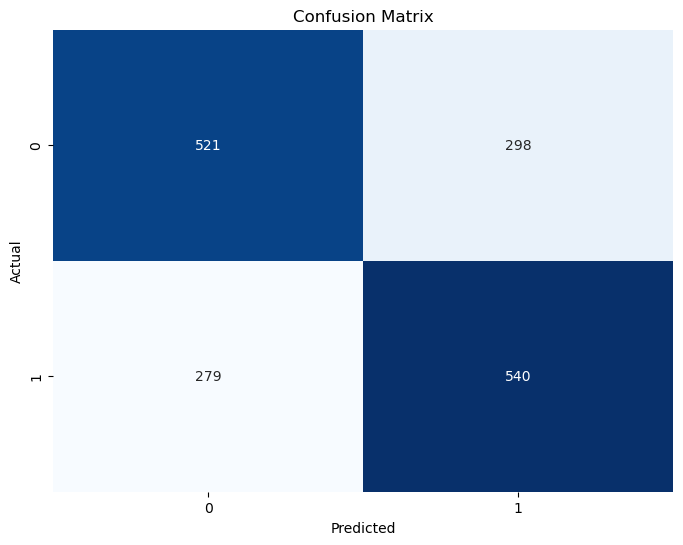

In [30]:
# Training the machine learning model 
from sklearn.ensemble import RandomForestClassifier

# Preprocessing - ensure these columns exist
matches_with_features['playerCode'] = matches_with_features['Player_1'].astype('category').cat.codes
matches_with_features['opponentCode'] = matches_with_features['Player_2'].astype('category').cat.codes
matches_with_features['target'] = (matches_with_features['Winner'] == matches_with_features['Player_1']).astype(int)

rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 3, random_state = 1)

# Divide the dataset into train and test sections
conditionDate = matches_with_features['date'] > '2005-01-01'
conditionDate2 = matches_with_features['date'] < '2023-10-29'
combinedCondition = conditionDate & conditionDate2 
train = matches_with_features[combinedCondition]

test = matches_with_features[matches_with_features["date"] > '2023-10-29']

# A list of all the prdictors 
#predictors = ["playerCode", "opponentCode", "Rank_1", "Rank_2", "Pts_1", "Pts_2", "Odd_1", "Odd_2"]
predictors = [
    "playerCode", "opponentCode", 
    "Rank_1", "Rank_2", "Pts_1", "Pts_2",
    "h2h_matches", "h2h_win_pct", "h2h_surface_matches", "h2h_surface_win_pct",
    "recent_matches_p1", "recent_win_pct_p1", "recent_avg_opp_rank_p1",
    "recent_matches_p2", "recent_win_pct_p2", "recent_avg_opp_rank_p2",
    "surface_hard", "surface_clay", "surface_grass"
]

# Fit the random forest model, fitting the predictors and trying to predict the target
rf.fit(train[predictors], train["target"])

prediction = rf.predict(test[predictors])

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test['target'], prediction)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, timedelta

def prepare_dataset(matches_with_features):
    """Prepare the dataset with additional features"""
    # Ensure these columns exist
    matches_with_features['date'] = pd.to_datetime(matches_with_features['date'])
    matches_with_features['playerCode'] = matches_with_features['Player_1'].astype('category').cat.codes
    matches_with_features['opponentCode'] = matches_with_features['Player_2'].astype('category').cat.codes
    matches_with_features['target'] = (matches_with_features['Winner'] == matches_with_features['Player_1']).astype(int)
    
    # Calculate days since match for recent form calculation
    matches_with_features['days_since_match'] = (datetime.now() - matches_with_features['date']).dt.days
    
    return matches_with_features



def get_head_to_head(player1, player2, surface=None, matches_df=None):
    """
    Get head-to-head statistics between two players
    
    Args:
        player1 (str): Name of Player 1
        player2 (str): Name of Player 2
        surface (str): Surface to filter by (None for all surfaces)
        matches_df (DataFrame): Matches dataset
        
    Returns:
        dict: Head-to-head statistics
    """
    # Filter matches where these players faced each other
    h2h_matches = matches_df[
        ((matches_df['Player_1'] == player1) & (matches_df['Player_2'] == player2)) |
        ((matches_df['Player_1'] == player2) & (matches_df['Player_2'] == player1))
    ]
    
    if surface:
        h2h_matches = h2h_matches[h2h_matches['Surface'] == surface]
    
    total_matches = len(h2h_matches)
    if total_matches == 0:
        return None
    
    player1_wins = len(h2h_matches[h2h_matches['Winner'] == player1])
    player2_wins = total_matches - player1_wins
    
    return {
        'total_matches': total_matches,
        f'{player1}_wins': player1_wins,
        f'{player2}_wins': player2_wins,
        f'{player1}_win_pct': player1_wins / total_matches,
        'surface': surface if surface else 'All'
    }

def get_recent_form(player, days=1000, matches_df=None):
    """
    Get recent performance statistics for a player
    
    Args:
        player (str): Player name
        days (int): Number of days to look back
        matches_df (DataFrame): Matches dataset
        
    Returns:
        dict: Recent performance statistics
    """
    recent_matches = matches_df[
        ((matches_df['Player_1'] == player) | (matches_df['Player_2'] == player)) &
        (matches_df['days_since_match'] <= days)
    ]
    
    total_matches = len(recent_matches)
    if total_matches == 0:
        return None
    
    wins = len(recent_matches[recent_matches['Winner'] == player])
    losses = total_matches - wins
    
    # Calculate average opponent rank faced
    opponent_ranks = []
    for _, row in recent_matches.iterrows():
        if row['Player_1'] == player:
            opponent_ranks.append(row['Rank_2'])
        else:
            opponent_ranks.append(row['Rank_1'])
    
    avg_opponent_rank = sum(opponent_ranks) / len(opponent_ranks) if opponent_ranks else 0
    
    return {
        'total_matches': total_matches,
        'wins': wins,
        'losses': losses,
        'win_pct': wins / total_matches,
        'avg_opponent_rank': avg_opponent_rank
    }

def predict_match(player1, player2, surface='Hard', matches_df=None, model=None, verbose=True):
    """
    Enhanced match prediction with head-to-head and recent form
    
    Args:
        player1 (str): Name of Player 1
        player2 (str): Name of Player 2
        surface (str): Court surface (Hard, Clay, Grass)
        matches_df (DataFrame): Matches dataset
        model: Trained model
        verbose (bool): Whether to print detailed output
        
    Returns:
        dict: Prediction results with detailed statistics
    """
    # Get current rankings (most recent entry for each player)
    player1_stats = matches_df[matches_df['Player_1'] == player1].iloc[-1]
    player2_stats = matches_df[matches_df['Player_2'] == player2].iloc[-1]
    
    # Get head-to-head stats (surface-specific and overall)
    h2h_surface = get_head_to_head(player1, player2, surface, matches_df)
    h2h_overall = get_head_to_head(player1, player2, None, matches_df)
    
    # Get recent form (last 14 days)
    recent_form_p1 = get_recent_form(player1, 1000, matches_df)
    recent_form_p2 = get_recent_form(player2, 1000, matches_df)
    
    # Ensure ALL predictors are included in both feature sets
    base_features = {
        "playerCode": matches_df.loc[matches_df['Player_1'] == player1, 'playerCode'].iloc[0],
        "opponentCode": matches_df.loc[matches_df['Player_2'] == player2, 'opponentCode'].iloc[0],
        "Rank_1": player1_stats['Rank_1'],
        "Rank_2": player2_stats['Rank_2'],
        "Pts_1": player1_stats['Pts_1'],
        "Pts_2": player2_stats['Pts_2'],
        "surface_hard": 1 if surface == 'Hard' else 0,
        "surface_clay": 1 if surface == 'Clay' else 0,
        "surface_grass": 1 if surface == 'Grass' else 0,
    }
    
    # Add H2H features if available
    h2h_features = {
        "h2h_matches": h2h_overall['total_matches'] if h2h_overall else 0,
        "h2h_win_pct": h2h_overall[f'{player1}_win_pct'] if h2h_overall else 0.5,
        "h2h_surface_matches": h2h_surface['total_matches'] if h2h_surface else 0,
        "h2h_surface_win_pct": h2h_surface[f'{player1}_win_pct'] if h2h_surface else 0.5,
    }
    
    # Add recent form features if available
    recent_features = {
        "recent_matches_p1": recent_form_p1['total_matches'] if recent_form_p1 else 0,
        "recent_win_pct_p1": recent_form_p1['win_pct'] if recent_form_p1 else 0.5,
        "recent_avg_opp_rank_p1": recent_form_p1['avg_opponent_rank'] if recent_form_p1 else 0,
        "recent_matches_p2": recent_form_p2['total_matches'] if recent_form_p2 else 0,
        "recent_win_pct_p2": recent_form_p2['win_pct'] if recent_form_p2 else 0.5,
        "recent_avg_opp_rank_p2": recent_form_p2['avg_opponent_rank'] if recent_form_p2 else 0,
    }
    
    # Combine all features
    features = {**base_features, **h2h_features, **recent_features}
    reverse_features = {
        "playerCode": features["opponentCode"],
        "opponentCode": features["playerCode"],
        "Rank_1": features["Rank_2"],
        "Rank_2": features["Rank_1"],
        "Pts_1": features["Pts_2"],
        "Pts_2": features["Pts_1"],
        "h2h_matches": features["h2h_matches"],
        "h2h_win_pct": 1 - features["h2h_win_pct"],
        "h2h_surface_matches": features["h2h_surface_matches"],
        "h2h_surface_win_pct": 1 - features["h2h_surface_win_pct"],
        "recent_matches_p1": features["recent_matches_p2"],
        "recent_win_pct_p1": features["recent_win_pct_p2"],
        "recent_avg_opp_rank_p1": features["recent_avg_opp_rank_p2"],
        "recent_matches_p2": features["recent_matches_p1"],
        "recent_win_pct_p2": features["recent_win_pct_p1"],
        "recent_avg_opp_rank_p2": features["recent_avg_opp_rank_p1"],
        "surface_hard": features["surface_hard"],
        "surface_clay": features["surface_clay"],
        "surface_grass": features["surface_grass"],
    }
    
    # Create dataframes ensuring all predictors are present
    prediction_df1 = pd.DataFrame([features])[predictors]
    prediction_df2 = pd.DataFrame([reverse_features])[predictors]
    
    # Verify columns match exactly
    if not all(col in prediction_df1.columns for col in predictors):
        missing = [col for col in predictors if col not in prediction_df1.columns]
        raise ValueError(f"Missing columns in prediction dataframe: {missing}")
    
    # Make predictions from both perspectives
    prob1 = model.predict_proba(prediction_df1)[0]
    prob2 = model.predict_proba(prediction_df2)[0]
    
    # Average the probabilities
    player1_win_prob = (prob1[1] + (1 - prob2[1])) / 2
    player2_win_prob = 1 - player1_win_prob
    
    predicted_winner = player1 if player1_win_prob > player2_win_prob else player2
    
    if verbose:
        print(f"\n=== Match Prediction: {player1} vs {player2} ===")
        print(f"Surface: {surface}")
        print(f"\nCurrent Rankings:")
        print(f"- {player1}: Rank {features['Rank_1']}, Points {features['Pts_1']}")
        print(f"- {player2}: Rank {features['Rank_2']}, Points {features['Pts_2']}")
        
        print(f"\nHead-to-Head (All Surfaces):")
        if h2h_overall:
            print(f"- Total matches: {h2h_overall['total_matches']}")
            print(f"- {player1} wins: {h2h_overall[f'{player1}_wins']}")
            print(f"- {player2} wins: {h2h_overall[f'{player2}_wins']}")
        else:
            print("- No previous matches found")
            
        print(f"\nHead-to-Head ({surface}):")
        if h2h_surface:
            print(f"- Total matches: {h2h_surface['total_matches']}")
            print(f"- {player1} wins: {h2h_surface[f'{player1}_wins']}")
            print(f"- {player2} wins: {h2h_surface[f'{player2}_wins']}")
        else:
            print("- No previous matches on this surface")
            
        print(f"\nRecent Form (Last X days):")
        print(f"{player1}:")
        if recent_form_p1:
            print(f"- Matches: {recent_form_p1['total_matches']}")
            print(f"- Wins: {recent_form_p1['wins']} ({recent_form_p1['win_pct']:.1%})")
            print(f"- Avg opponent rank: {recent_form_p1['avg_opponent_rank']:.1f}")
        else:
            print("- No recent matches")
            
        print(f"\n{player2}:")
        if recent_form_p2:
            print(f"- Matches: {recent_form_p2['total_matches']}")
            print(f"- Wins: {recent_form_p2['wins']} ({recent_form_p2['win_pct']:.1%})")
            print(f"- Avg opponent rank: {recent_form_p2['avg_opponent_rank']:.1f}")
        else:
            print("- No recent matches")
            
        print(f"\nPrediction:")
        print(f"- {player1} win probability: {player1_win_prob:.2%}")
        print(f"- {player2} win probability: {player2_win_prob:.2%}")
        print(f"Predicted winner: {predicted_winner}")
    
    return {
        'player1': player1,
        'player2': player2,
        'surface': surface,
        'player1_win_prob': player1_win_prob,
        'player2_win_prob': player2_win_prob,
        'predicted_winner': predicted_winner,
        'h2h_stats': h2h_surface if h2h_surface else h2h_overall,
        'recent_form_p1': recent_form_p1,
        'recent_form_p2': recent_form_p2
    }

# Example usage:
# Prepare the dataset
matches_with_features = prepare_dataset(matches_with_features)

# Train the model with the enhanced features
predictors = [
    "playerCode", "opponentCode", 
    "Rank_1", "Rank_2", "Pts_1", "Pts_2",
    "h2h_matches", "h2h_win_pct", "h2h_surface_matches", "h2h_surface_win_pct",
    "recent_matches_p1", "recent_win_pct_p1", "recent_avg_opp_rank_p1",
    "recent_matches_p2", "recent_win_pct_p2", "recent_avg_opp_rank_p2",
    "surface_hard", "surface_clay", "surface_grass"
]

# You'll need to calculate these features for your training data first
# This would involve creating these columns in your training dataset
# For demonstration, I'm assuming you'll add these features to your training data


# Split data - Updated version
train = matches_with_features[
    (matches_with_features['date'] >= '2000-01-03') & 
    (matches_with_features['date'] <= '2022-12-31')  # Train on first 23 years
]

test = matches_with_features[
    (matches_with_features['date'] >= '2023-01-01') & 
    (matches_with_features['date'] <= '2024-06-29')  # Test on most recent 1.5 years
]

# Train model
rf = RandomForestClassifier(n_estimators=200, min_samples_split=3, random_state=1)
rf.fit(train[predictors], train["target"])

# Make a prediction
player_a = "Sinner J."
player_b = "Alcaraz C."
surface = "Clay"

# Check if the required columns exist
required_columns = [
    'h2h_matches', 'h2h_win_pct', 'h2h_surface_matches', 'h2h_surface_win_pct',
    'recent_matches_p1', 'recent_win_pct_p1', 'recent_avg_opp_rank_p1',
    'surface_hard', 'surface_clay', 'surface_grass'
]

missing = [col for col in required_columns if col not in matches_with_features.columns]
if missing:
    print(f"Missing columns: {missing}")
else:
    print("All required features are present")

if player_a in matches_with_features['Player_1'].values and player_b in matches_with_features['Player_2'].values:
    result = predict_match(player_a, player_b, surface, matches_with_features, rf)
else:
    print("One or both players not found in dataset.")
    # Find similar players
    similar_a = matches_with_features[matches_with_features['Player_1'].str.contains(player_a.split()[0])]['Player_1'].unique()
    similar_b = matches_with_features[matches_with_features['Player_2'].str.contains(player_b.split()[0])]['Player_2'].unique()
    print(f"Similar to {player_a}: {similar_a}")
    print(f"Similar to {player_b}: {similar_b}")

All required features are present

=== Match Prediction: Sinner J. vs Alcaraz C. ===
Surface: Clay

Current Rankings:
- Sinner J.: Rank 1, Points 9480
- Alcaraz C.: Rank 3, Points 7300

Head-to-Head (All Surfaces):
- Total matches: 9
- Sinner J. wins: 4
- Alcaraz C. wins: 5

Head-to-Head (Clay):
- Total matches: 2
- Sinner J. wins: 1
- Alcaraz C. wins: 1

Recent Form (Last X days):
Sinner J.:
- Matches: 118
- Wins: 99 (83.9%)
- Avg opponent rank: 53.2

Alcaraz C.:
- Matches: 112
- Wins: 93 (83.0%)
- Avg opponent rank: 50.8

Prediction:
- Sinner J. win probability: 50.17%
- Alcaraz C. win probability: 49.83%
Predicted winner: Sinner J.
